In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from utils import *


In [2]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2 , 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2 , 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

In [3]:
spec_data, sgx_data, ref_data = readData()
data = pd.concat([ref_data, sgx_data, spec_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)
data.head()

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2,SPEC-O3,SPEC-CO,SPEC-NO2,SPEC-SO2
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


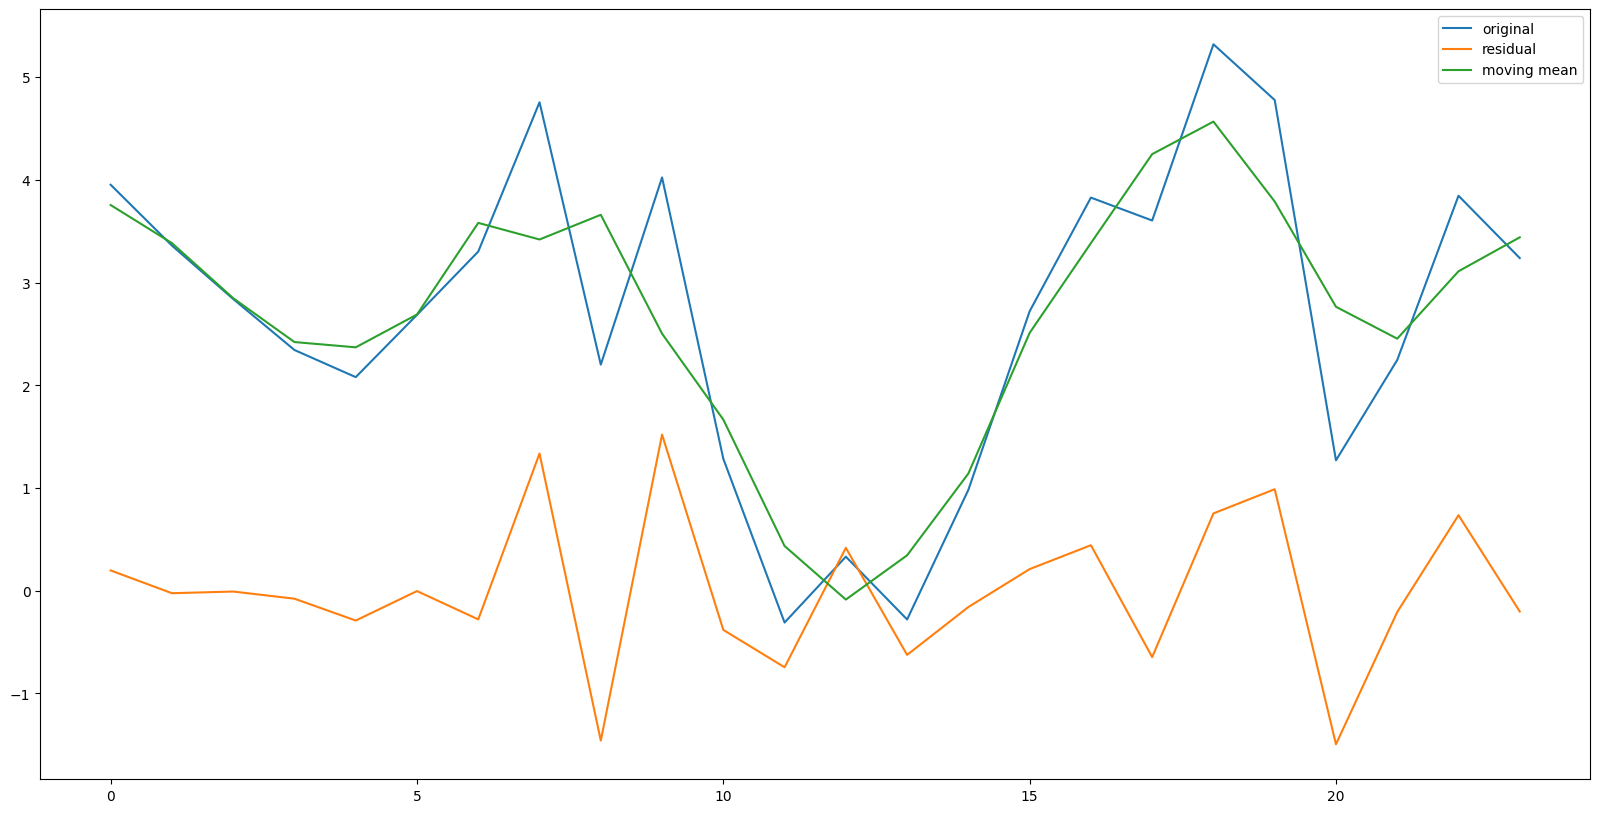

In [33]:
m_data = data.loc[data.index.month == 8, ['SGX-CO']].dropna().values[:24]
m_data = torch.tensor(m_data.reshape(1, -1, 1))
decomp = series_decomp(3)

res, moving_mean = decomp(m_data)

plt.figure(figsize=(20, 10))
plt.plot(m_data[0, :, 0].numpy(), label='original')
plt.plot(res[0, :, 0].numpy(), label='residual')
plt.plot(moving_mean[0, :, 0].numpy(), label='moving mean')
plt.legend()
plt.show()